In [57]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.utils import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 255)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
%pwd
import os
os.chdir('../')
%pwd

'e:\\Hate_Speech_Classification'

In [8]:
from zipfile import ZipFile
file_path=r"archive.zip"
with ZipFile(file_path,'r') as zip_doc:
    zip_doc.extractall('research/')

In [11]:
raw=pd.read_csv(r"E:\Hate_Speech_Classification\research\labeled_data.csv")
raw.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [12]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


## Data Cleaning

In [13]:
#Removing unwanted columns
df=raw.drop(columns=['neither','Unnamed: 0','hate_speech','count','offensive_language'])
print('Columns Dropped 👍')

Columns Dropped 👍


In [14]:
#Check ing with Nul Values
df.isnull().sum()

class    0
tweet    0
dtype: int64

## EDA

<Axes: xlabel='class', ylabel='count'>

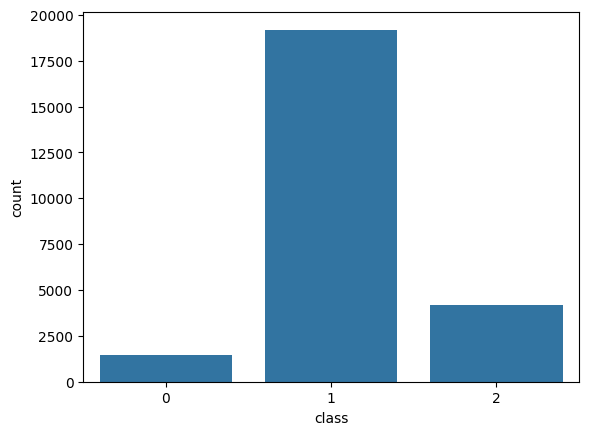

In [15]:
sns.countplot(x=df['class'])

**Insights**
1. class 0: hate, class 1: abusive, and class 2: no hate.
- Let's copy the valus of the class 1 into class 0.

## Data Preprocessing/Feature Extraction

<Axes: xlabel='label', ylabel='count'>

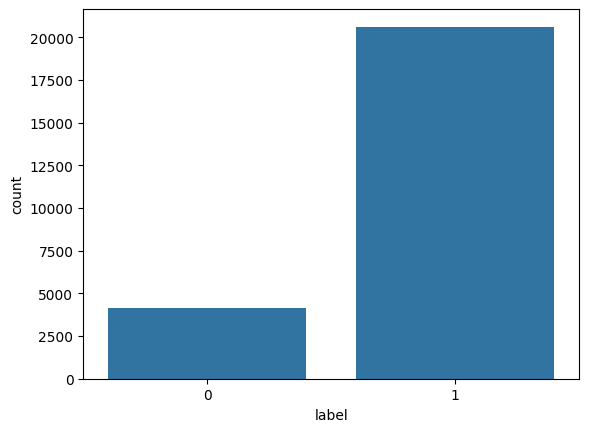

In [16]:
# replace the value of 0 to 1
df["class"].replace({0:1},inplace=True)
# Let's replace the value of 2 to 0.
df["class"].replace({2:0}, inplace = True)
# Let's change the name of the 'class' to label
df.rename(columns={'class':'label'},inplace =True)
#plotting class column
sns.countplot(x=df['label'])

**We can see that data is imbalanced lets resolve it while trianing the model**

In [17]:
df.iloc[0]['tweet']

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [18]:
# Let's apply stemming and stopwords on the data
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

In [19]:
# Let's apply regex and do cleaning. 
def data_cleaning(words):
    words = str(words).lower()
    words = re.sub('\[.*?\]', '', words)
    words = re.sub('https?://\S+|www\.\S+', '', words)
    words = re.sub('<.*?>+', '', words)
    words = re.sub('[%s]' % re.escape(string.punctuation), '', words)
    words = re.sub('\n', '', words)
    words = re.sub('\w*\d\w*', '', words)
    words = [word for word in words.split(' ') if words not in stopword]
    words=" ".join(words)
    words = [stemmer.stem(words) for word in words.split(' ')]
    words=" ".join(words)

    return words

In [20]:
# let's apply the data_cleaning on the data.
df['tweet']=df['tweet'].apply(data_cleaning)

In [60]:
df.to_csv('E:/Hate_Speech_Classification/research/cleaned_data.csv',index=False)
df.head(10)

,label,tweet
0,0,rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the tra...
1,1,rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac...
2,1,rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start ...
3,1,rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cgander...
4,1,rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts th...
5,1,tmadisonx the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes tmadisonx the shit just blows meclaim you so faithful and down for somebody but still fucking with hoes tmadisonx the shit just blows meclaim you...
6,1,brighterdays i can not just sit up and hate on another bitch i got too much shit going on brighterdays i can not just sit up and hate on another bitch i got too much shit going on brighterdays i can not just sit up and hate on another bitch i got t...
7,1,cause im tired of you big bitches coming for us skinny cause im tired of you big bitches coming for us skinny cause im tired of you big bitches coming for us skinny cause im tired of you big bitches coming for us skinny cause im tired of you ...
8,1,amp you might not get ya bitch back amp thats that amp you might not get ya bitch back amp thats that amp you might not get ya bitch back amp thats that amp you might not get ya bitch back amp thats that amp you might not get ya bitch back am...
9,1,rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx hobbies include fighting mariambitch rhythmixx ...


In [ ]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Apply Label Encoding
le = LabelEncoder()
df['tweet_Encoded'] = le.fit_transform(df['tweet'])

# Separate Features & Target
X = df['tweet_Encoded']
y = df['label']  # Example binary target

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.values.reshape(-1,1), y)

# Convert Encoded Category Back to Original Form
# Convert Encoded Category Back to Original Form
X_resampled = pd.DataFrame(X_resampled, columns=['tweet_Encoded'])  # Convert back to DataFrame
X_resampled['tweet_Original'] = le.inverse_transform(X_resampled['tweet_Encoded'].astype(int))  # Decode

# View Results
print(X_resampled.head())


   tweet_Encoded  \
0           1827   
1           1792   
2           1848   
3           1811   
4           1841   

                                                                                                                                                                                                                                                   tweet_Original  
0   rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the tra...  
1   rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac  rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac  rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac  rt  boy dats coldtyga dwn bad for cuffin dat hoe in the  plac...  
2   rt urkindofbrand dawg rt  you ever fuck a bitch and she start to cry you be confused as shit  r

In [15]:
X_resampled.head()

,tweet_Encoded,tweet_Original
0,1827,rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the tra...
1,1792,rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac rt boy dats coldtyga dwn bad for cuffin dat hoe in the plac...
2,1848,rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start to cry you be confused as shit rt urkindofbrand dawg rt you ever fuck a bitch and she start ...
3,1811,rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cganderson vivabased she look like a tranni rt cgander...
4,1841,rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts the shit you hear about me might be true or it might be faker than the bitch who told it to ya rt shenikaroberts th...


In [16]:
y_resampled

0        0
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
30       1
31       1
32       1
33       1
34       1
35       1
36       1
37       1
38       1
39       1
40       0
41       1
42       1
43       1
44       1
45       1
46       1
47       1
48       1
49       1
50       1
51       1
52       1
53       1
54       1
55       1
56       1
57       1
58       1
59       1
60       1
61       1
62       1
63       0
64       1
65       1
66       0
67       0
68       1
69       1
70       0
71       1
72       1
73       1
74       1
75       0
76       1
77       1
78       1
79       1
80       1
81       1
82       1
83       1
84       1
85       1
86       1
87       1
88       1
89       1
90       1

## Model Training

In [22]:
x = df['tweet']
y = df['label']

In [23]:
# Let's split the data into train and test
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 42)
print('x_train shape:',x_train.shape)
print('y_train shape:',y_train.shape)
print('x_test shape:',x_test.shape)
print('y_test shape:',y_test.shape)

x_train shape: (18587,)
y_train shape: (18587,)
x_test shape: (6196,)
y_test shape: (6196,)


In [24]:
type(x_test), type(y_test), type(x_train), type(y_train)

(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [24]:
len(x_test)

6196

In [25]:
max_words = 50000
max_len = 300

In [26]:
# Creating model architecture.
model = Sequential()
model.add(Embedding(max_words,100,input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add((LSTM(100,dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(1,activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,080,501
Trainable params: 5,080,501
Non-trainable params: 0
_________________________________________________________________


In [56]:
float(x_train[0])
type(x_train[0])

ValueError: could not convert string to float: ' rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out  rt mayasolovely as a woman you shouldnt complain about cleaning up your house amp as a man you should always take the trash out'

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [28]:
# starting model training
#early_stop=EarlyStopping(monitor='val_loss',patience=3)
history = model.fit(sequences_matrix,np.array(y_train),batch_size=128,epochs = 1,
                   validation_split=0.2)# callbacks=[early_stop])

117/117 [==============================] - 675s 6s/step - loss: 0.2749 - accuracy: 0.8917 - val_loss: 0.2337 - val_accuracy: 0.9328


In [29]:
test_sequences = tokenizer.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [30]:
# Model evaluation
accr = model.evaluate(test_sequences_matrix,y_test)

194/194 [==============================] - 16s 80ms/step - loss: 0.2772 - accuracy: 0.9238


In [33]:
lstm_prediction = model.predict(test_sequences_matrix)

194/194 [==============================] - 10s 52ms/step


In [34]:
res = []
for prediction in lstm_prediction:
    if prediction[0] < 0.5:
        res.append(0)
    else:
        res.append(1)

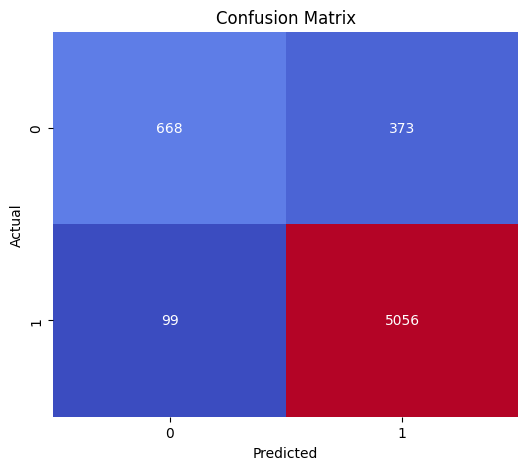

In [37]:
cm=confusion_matrix(y_test,res)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

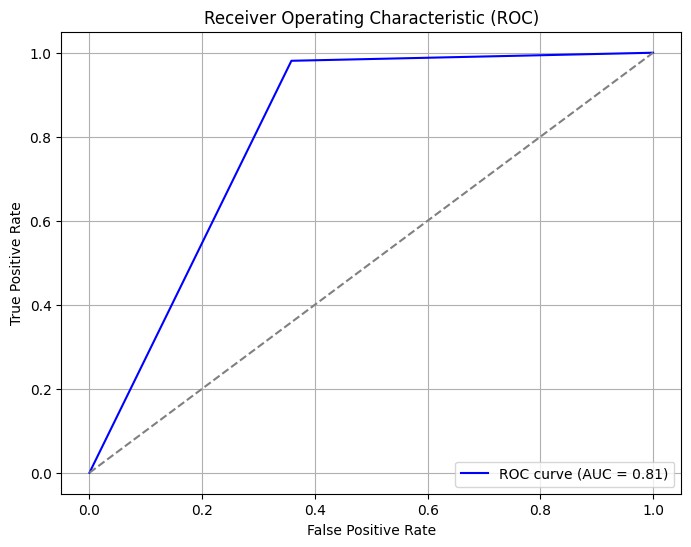

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, res)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

- Seems model has 81% probability of distinguishing between positive and negative classes.
- The blue line shows your model's ability to separate classes.
- A steeper climb (closer to the top-left corner) means better performance.

- The dashed diagonal line represents a random classifier (AUC = 0.5). Since your curve is well above it, your model is performing better than random guessing.
- LSTM is performing well, but there's room for improvement (closer to 1.0 is ideal).

In [39]:

import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# Let's save the mdoel.
model.save("model.h5")

In [41]:
import keras
load_model=keras.models.load_model("model.h5")
with open('tokenizer.pickle', 'rb') as handle:
    load_tokenizer = pickle.load(handle)

In [42]:
# Let's test our model on custom data.
test = 'humans are idiots'
def clean_text(text):
    print(text)
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    print(text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
test=[clean_text(test)]
print(test)
seq = load_tokenizer.texts_to_sequences(test)
padded = pad_sequences(seq, maxlen=300)
print(seq)
pred = load_model.predict(padded)
print("pred", pred)
if pred<0.5:
    print("no hate")
else:
    print("hate and abusive")

humans are idiots
humans are idiots
['human idiot']
[[946, 1536]]
1/1 [==============================] - 0s 267ms/step
pred [[0.94266486]]
hate and abusive
